In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse

from tsprial.model_selection import TemporalSplit
from tsprial.forecasting import ForecastingChain

In [3]:
### UTILITY FUNCTION TO GENERATE SINUSOIDAL DATA ###

def gen_sinusoidal(timesteps, amp, freq, noise, kind='sin', random_state=0):
    np.random.seed(random_state)
    X = np.arange(timesteps)
    e = np.random.normal(0,noise, (timesteps,))
    if kind == 'sin':
        y = amp*np.sin(X*(2*np.pi/freq))+e
    elif kind == 'cos':
        y = amp*np.cos(X*(2*np.pi/freq))+e
    else:
        assert False
    return y

In [4]:
### GENERATE SINUSOIDAL SERIES ###

n_series, timesteps = 30, 800

df = {}
for i in range(n_series):
    df[f'ts_{i}'] = gen_sinusoidal(
        timesteps, amp=10, freq=24, noise=20, 
        kind = ('sin' if i%3 > 0 else 'cos'),
        random_state=i
    )
df = pd.DataFrame(
    df, index=pd.date_range(
        '2020-01-01', periods=timesteps, freq='H'
    )
)

df.shape

(800, 30)

<AxesSubplot:>

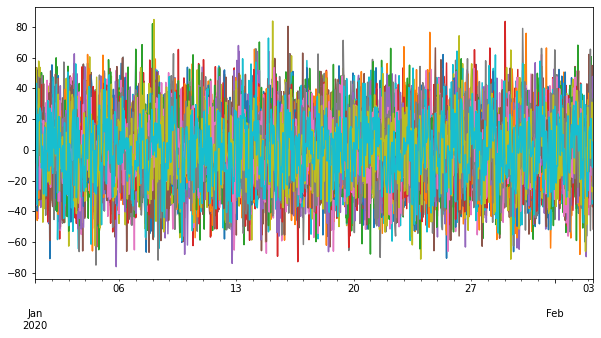

In [5]:
### PLOT SINUSOIDAL DATA ###

df.plot(legend=False, figsize=(10,5))

In [6]:
### DYNAMIC FACTOR MODELING (DFM) FORECASTING ###

cv = TemporalSplit(n_splits=10, test_size=24, gap=5)
scaler_pca = make_pipeline(StandardScaler(), PCA(n_components=2))
forecaster = ForecastingChain(
    Ridge(),
    n_estimators=cv.test_size,
    lags=range(1,13),
    use_exog=False,
    n_jobs=-1,
)
dfm_error = pd.DataFrame({'DFM': dict(zip(df.columns, np.zeros_like(df.columns, dtype=float)))})

for id_train,id_test in cv.split(df):

    df_train_pca = scaler_pca.fit_transform(df.iloc[id_train])

    forecaster.fit(None, df_train_pca)
    y_pred_dfm = forecaster.predict(np.arange(len(id_test)))

    y_pred_dfm = scaler_pca.steps[0][-1].inverse_transform(
        scaler_pca.steps[-1][-1].inverse_transform(y_pred_dfm)
    )
    y_pred_dfm = pd.DataFrame(y_pred_dfm, columns=df.columns, index=df.iloc[id_test].index)

    dfm_error += pd.DataFrame({
        'DFM': dict(zip(df.columns, 
                 mse(df.iloc[id_test], y_pred_dfm, squared=False, multioutput='raw_values')
                )
            )
    })
    
dfm_error = dfm_error / cv.n_splits
dfm_error.mean()

DFM    19.832434
dtype: float64

In [7]:
### MULTIVARIATE DIRECT FORECASTING ###

cv = TemporalSplit(n_splits=10, test_size=24, gap=5)
forecaster = ForecastingChain(
    make_pipeline(StandardScaler(), Ridge()),
    n_estimators=cv.test_size,
    lags=range(1,13),
    use_exog=False,
    n_jobs=-1,
)
direct_error = pd.DataFrame({'Direct': dict(zip(df.columns, np.zeros_like(df.columns, dtype=float)))})

for id_train,id_test in cv.split(df):

    forecaster.fit(None, df.iloc[id_train])
    y_pred_direct = forecaster.predict(np.arange(len(id_test)))

    y_pred_direct = pd.DataFrame(y_pred_direct, columns=df.columns, index=df.iloc[id_test].index)

    direct_error += pd.DataFrame({
        'Direct': dict(zip(df.columns, 
                 mse(df.iloc[id_test], y_pred_direct, squared=False, multioutput='raw_values')
                )
            )
    })

direct_error = direct_error / cv.n_splits
direct_error.mean()

Direct    27.79028
dtype: float64

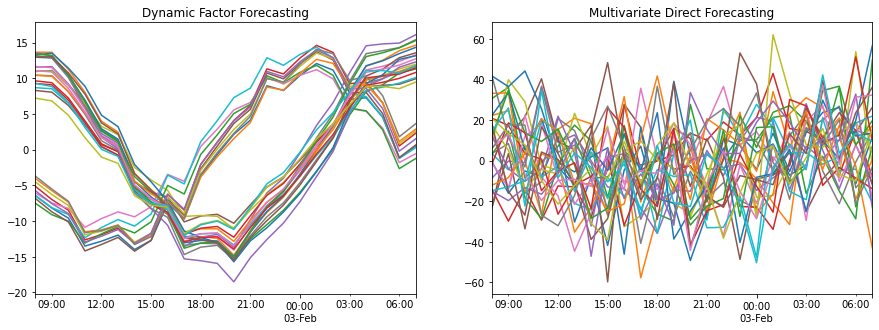

In [8]:
### VISUAL COMPARISON OF FORECASTING METHODS ###

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
y_pred_dfm.plot(legend=False, title='Dynamic Factor Forecasting', ax=plt.gca())
plt.subplot(1,2,2)
y_pred_direct.plot(legend=False, title='Multivariate Direct Forecasting', ax=plt.gca())
plt.show()

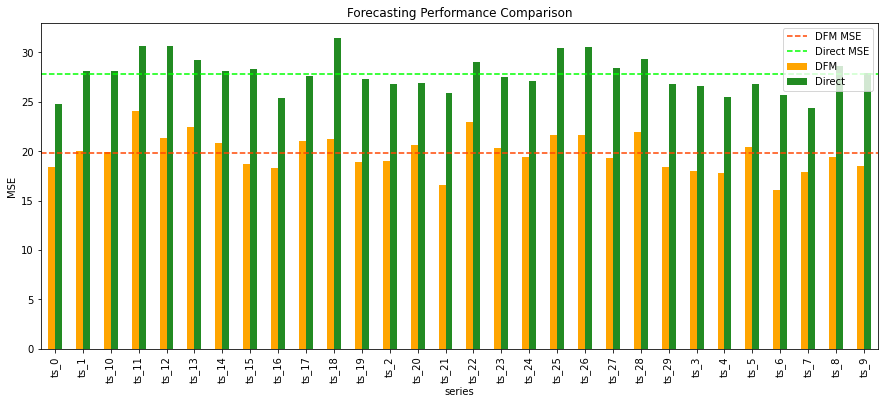

In [9]:
### PERFORMANCE COMPARISON OF FORECASTING METHODS ###

dfm_error.join(direct_error).plot.bar(stacked=False, figsize=(15,6), color=['orange','forestgreen'])
plt.ylabel('MSE'); plt.xlabel('series')
plt.axhline(dfm_error.mean().squeeze(), label='DFM MSE', linestyle='--', c='orangered')
plt.axhline(direct_error.mean().squeeze(), label='Direct MSE', linestyle='--', c='lime')

plt.title('Forecasting Performance Comparison')
plt.legend()
plt.show()